In [2]:
import pandas as pd
import numpy as np
import os
import ast
import sys
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')



This is a second level of imports, using packages built for this context

In [ ]:
additional_code_path = '/Users/briandalessandro/Documents/CrossBoundary/code/rf2019-crossboundary'

sys.path.append(additional_code_path)
from CbModelBuilder.CbModelBuilderUtils import non_model_features, evaluate_regression,evaluate_classification,cap_outlier,train_test_split,plot_confusion_matrix
from CbModelBuilder.FeatureImportanceSummary import FeatureImportanceSummary
from CbModelBuilder.ModelCVWrapper import ModelCVWrapper


In [ ]:
Set up file paths (these should be changed based on whatever local file system logic you have set up)

In [ ]:
data_dir_june = '/Users/briandalessandro/Documents/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
modelfile_reg = '/Users/briandalessandro/Documents/CrossBoundary/models/random_forest_regression.pickle'
modelfile_class = '/Users/briandalessandro/Documents/CrossBoundary/models/random_forest_classifier.pickle'


Read in data and model

In [10]:
#Data
model_df = pd.read_csv(data_dir_june + 'training_all_in.csv')

#Regression Model
with open(modelfile_reg, 'rb') as r:
    reg_model = pickle.load(r)
    
#Classification Model
with open(modelfile_class, 'rb') as r:
    class_model = pickle.load(r)

Use the regression model to get expected consumption at current and different price points

In [11]:
#Get the expected consumption level at factual price
model_df['exp_consumption_fp'] = reg_model.best_model.predict(model_df[reg_model.best_subset])

tariff_quantiles = np.percentile(model_df['tariff'], [10,25,50,75,90])

preds = []
for i, tar in enumerate(tariff_quantiles):
    pd_test = model_df.copy()    
    pd_test['tariff'] = tar
    
    preds.append(reg_model.best_model.predict(pd_test[reg_model.best_subset]))
    
    
for i,q in enumerate([10,25,50,75,90]):
    model_df['exp_consumption_cf_{}'.format(q)] = preds[i]

Use the classifier to predict if a hh will be in the top 10%

In [13]:
model_df['exp_in_top_decile'] = class_model.best_model.predict(model_df[class_model.best_subset])


These are the variables we'll consider

In [38]:


demo_vars = ['age','educ_years','employment_status','years_in_community',
            'type_of_house','hh_size_between_5_18','hh_income','hh_expenses']

predictive_vars = ['tariff', 'non_self_generated_electricity_monthly_consumption_kwh',
       'energy', 'uses_of_non_self_generated_electricity_has_fan',
       'cooking_tech', 'rent',
       'non_self_generated_electricity_monthly_expenses', 'sleep_time',
       'hours_of_use_on_days_used_of_lighting_items',
       'fetching_time_minutes',
       'hours_of_use_on_days_used_of_lighting_items_by_interviewee',
       'rank_appliances_to_buy__3rd_choice', 'phone_charger_type_of_use',
       'achieved_important_things_i_want',
       'non_self_generated_electricity_unit_price_per_kw']


outcome_vars = ['avg_consumption','exp_consumption_fp','exp_consumption_cf_10','exp_consumption_cf_25',
                'exp_consumption_cf_50','exp_consumption_cf_75','exp_consumption_cf_90','exp_in_top_decile']



Use ANOVA to determine which variables have statistically significant variation across villages (as well as being a driver / predictor of consumption).

In [39]:
anova_vars = []
for an_var in demo_vars + predictive_vars:
    mod = ols('{} ~ village_code'.format(an_var), data=model_df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    pval = aov_table.iloc[0]['PR(>F)']
    if pval < .05:
        print('{} {}'.format(an_var, pval))
        anova_vars.append(an_var)

educ_years 0.00014930295592442434
years_in_community 1.3437595230327818e-05
type_of_house 0.0006800091686819656
hh_income 6.814276257651065e-07
hh_expenses 2.411182124699674e-10
tariff 1.4316581381236105e-11
uses_of_non_self_generated_electricity_has_fan 0.00010390421876630629
rent 3.557844763873626e-07
non_self_generated_electricity_monthly_expenses 1.4079436218817251e-05
sleep_time 9.857609322305463e-12
achieved_important_things_i_want 0.0014795631873559193
non_self_generated_electricity_unit_price_per_kw 2.2066251874323194e-09


Now get the mean profile of each village, and also standardize them.

In [109]:
x_std = pd.DataFrame(StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(model_df[anova_vars]))
x_std.columns = anova_vars
x_std['village_code'] = model_df['village_code']
x_std_grp = model_df[anova_vars + ['village_code']].groupby('village_code').mean().reset_index()


In [110]:
anova_df = model_df[anova_vars + ['village_code']].groupby('village_code').mean().reset_index()
anova_df

,village_code,educ_years,years_in_community,type_of_house,hh_income,hh_expenses,tariff,uses_of_non_self_generated_electricity_has_fan,rent,non_self_generated_electricity_monthly_expenses,sleep_time,achieved_important_things_i_want,non_self_generated_electricity_unit_price_per_kw
0,0,7.000000,30.000000,3.000000,88.000000,73.920000,0.724108,0.000000,0.000000,10000.000000,21.500000,3.000000,5000.000000
1,1,7.426829,32.182927,2.951220,125.628293,118.571427,1.238369,0.219512,0.407805,16537.902439,21.134959,2.695122,5024.512195
2,2,7.352941,33.268908,3.126050,104.564706,75.284399,1.708534,0.134454,0.240336,8159.663866,21.948319,2.344538,2110.084034
3,3,6.810573,35.277533,3.096916,78.149427,84.383568,2.044814,0.189427,0.031013,15312.775330,20.090749,2.334802,4503.083700
4,4,6.994751,25.509186,3.065617,102.528084,85.938677,2.118251,0.154856,0.992030,15643.569554,21.374891,2.971129,4726.950131
5,5,7.171141,31.204698,2.708054,89.860403,69.087456,2.304952,0.164430,0.228859,14348.993289,21.417114,2.835570,4906.409396
6,6,7.635922,30.422330,2.679612,117.931107,84.925573,2.299071,0.063107,0.574990,13451.456311,21.394337,2.665049,4841.747573
7,7,8.141304,29.152174,3.163043,148.906522,167.908543,1.413489,0.010870,3.634783,3619.717391,19.371196,2.304348,1518.478261
8,8,8.186364,31.504545,3.481818,181.848000,148.201666,1.711998,0.040909,2.816000,7541.590909,18.002348,2.522727,3080.659091
9,9,6.423913,20.597826,2.858696,261.823913,119.531777,0.986080,0.380435,0.573951,15989.130435,21.847464,3.032609,1869.565217


In [44]:
outcome_df = model_df[outcome_vars + ['village_code']].groupby('village_code').mean().reset_index()
outcome_df

,village_code,avg_consumption,exp_consumption_fp,exp_consumption_cf_10,exp_consumption_cf_25,exp_consumption_cf_50,exp_consumption_cf_75,exp_consumption_cf_90,exp_in_top_decile
0,0,0.077106,0.113462,0.180301,0.105988,0.045599,0.034872,0.029001,0.000000
1,1,0.187053,0.165431,0.179594,0.113160,0.063790,0.050025,0.044790,0.097561
2,2,0.105184,0.085777,0.187146,0.112112,0.045220,0.038020,0.033873,0.025210
3,3,0.059309,0.073522,0.171305,0.110388,0.062548,0.040749,0.035386,0.022026
4,4,0.099165,0.078082,0.225548,0.117264,0.058315,0.047122,0.042994,0.055118
5,5,0.074130,0.057967,0.176887,0.108699,0.058015,0.044448,0.039463,0.020134
6,6,0.064668,0.059627,0.166507,0.109434,0.055377,0.044706,0.039150,0.019417
7,7,0.068462,0.077979,0.104231,0.113233,0.059740,0.049901,0.045464,0.021739
8,8,0.107014,0.096655,0.193636,0.126705,0.062561,0.056264,0.052260,0.059091
9,9,0.427615,0.250127,0.259476,0.116051,0.061281,0.053395,0.050382,0.467391


In [111]:
X_em = TSNE(n_components=2).fit_transform(x_std_grp)
Y_em = TSNE(n_components=2).fit_transform(outcome_df)

In [112]:
x_em_df = pd.DataFrame(X_em, columns = ['x1','x2'])
y_em_df = pd.DataFrame(Y_em, columns = ['y1','y2'])
vcnt = pd.DataFrame(model_df.village_code.value_counts())
vcnt.columns = ['cnt']

em_df = x_em_df.merge(vcnt, left_index=True, right_index=True).merge(y_em_df, left_index=True, right_index=True)

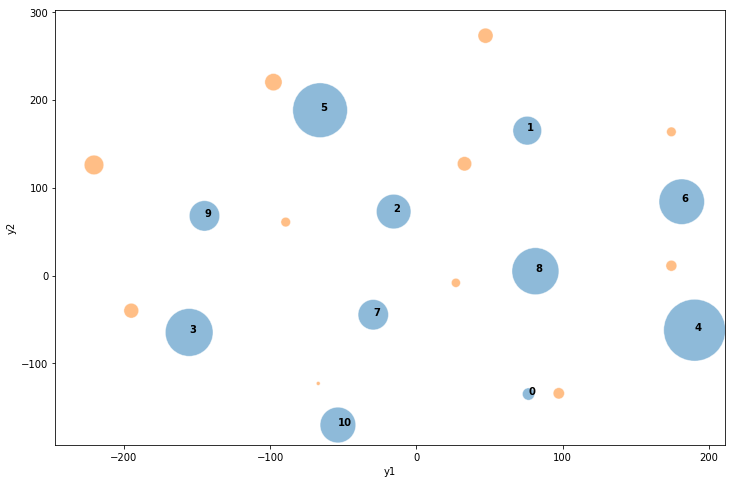

In [113]:
plt.figure(figsize=(12,8))
ax1 = sns.scatterplot(em_df.x1, em_df.x2, alpha = 0.5, s =10* em_df.cnt)
ax2 = sns.scatterplot(em_df.y1, em_df.y2, alpha = 0.5, s = em_df.cnt)

for line in range(0,em_df.shape[0]):
     ax1.text(em_df.x1[line], em_df.x2[line], 
     em_df.index.values[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')